# Reduce rows to one per family
* Starting point: A file which only contains the last flight segment of the TRUE_OD itinerary. 
    * This was identified by equating the destination of TRUE_OD and the destination of SEGMENT_OD
    * I only keep flights where the country of origin corresponds to the country of the country of the origin 

Requirement: work in torch environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as rex
import date_library as datelib
import utils as u

In [5]:
start_file = "reduced_df.csv"

In [6]:
# df = pd.read_csv("activity_top10e5.csv", nrows=100000, )
df = pd.read_csv(
    start_file,
    nrows=None,
)
df0 = df.copy()
df.shape

(865446, 23)

# Analyze membership, families, etc
* There is already a 1-1 correspondance between PNR and member ids
* Rows with undefined PNR have been removed (about 50k rows)

## Remove all records where one PNR has multiple MEMBER_IDs
* At least until we understand this case better

### How many TICKET_NUMBERs for each PNR?
* I would expect one per person if several people are covered. 
* How many MEMBER_IDs per PNR? I would expect 1

In [7]:
cols_pnr = [
    "PNR",
    "FLIGHT_DATE",
    "OPERATING_FLIGHT_NUMBER",
    "SEGMENT_OD",
    "TRUE_OD",
    "TICKET_NUMBER",
]

In [8]:
df = u.remove_flights_within_country(df)
df.shape

(865446, 23)

### (PNR, FLIGHT#, FLIGHT_date) should be unique
* different ticket numbers corresponding to a reservation 
  made by a single member that are the same flight should be counted as 1. 
* The number of different tickets would be the family size (TODO)

In [9]:
dfg = df.groupby(['PNR','OPERATING_FLIGHT_NUMBER','FLIGHT_DATE'])
#dfg.size().sort_values(ascending=False).iloc[32000:32050]
dfgdf = dfg.size().to_frame('size')
xx = dfg['FLIGHT_DATE'].transform('size')
xx.shape

(865446,)

In [10]:
cols_drop = ["PNR", "FLIGHT_DATE", "OPERATING_FLIGHT_NUMBER"]

## Identify the number of family members per trip 

In [11]:
df.shape

(865446, 23)

In [12]:
df1 = u.party_size(df)
party_size = df1.PARTY_SZ
print(type(party_size))

max party siz:  1
<class 'pandas.core.series.Series'>


In [13]:
df.shape, df1.shape, party_size.shape, len(party_size)

((865446, 24), (865446, 24), (865446,), 865446)

In [14]:
party_size.value_counts(), party_size.value_counts().sum()

(1    865446
 Name: PARTY_SZ, dtype: int64,
 865446)

In [19]:
df.shape

(865446, 24)

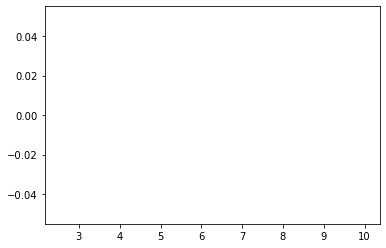

In [15]:
plt.hist(party_size, range=(2.54, 10));

In [20]:
df1 = u.one_record_per_family(df)
df1.shape

(865446, 24)

In [21]:
df1.groupby("MEMBER_ID").size().shape

(50793,)

In [22]:
df.groupby("MEMBER_ID").size().shape

(50793,)

In [23]:
df.groupby("MEMBER_ID").size().shape

(50793,)

In [24]:
df.groupby("PNR").size().shape, df1.groupby("PNR").size().shape

((862409,), (862409,))

## 50793 member ids, 862409 PNRs. 

In [25]:
dfg = df1.groupby(["PNR", "OPERATING_FLIGHT_NUMBER", "FLIGHT_DATE"])
dfg.size().max()

1

In [26]:
df.shape, df1.shape

((865446, 24), (865446, 24))

In [27]:
df[df["PNR"] == "AP1XOQ"][cols_pnr]

,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER
491545,AP1XOQ,1621641600,446,PTY-MCO,PTY-MCO,2.302176e+12


In [28]:
df.columns

Index(['MEMBER_ID', 'PNR', 'BOOKING_DATE', 'FLIGHT_DATE', 'TICKET_SALES_DATE',
       'REVENUE_AMOUNT', 'AWARD_MILES', 'FLOWN_CLASS', 'AMOUNT_OF_BAGS',
       'TRUE_OD', 'HOLDING_OD', 'SEGMENT_OD', 'SEGMENT_ORIGIN_REGION',
       'SEGMENT_DESTINATION_REGION', 'SEGMENT_ORIGIN_COUNTRY',
       'SEGMENT_DESTINATION_COUNTRY', 'TICKET_NUMBER',
       'OPERATING_FLIGHT_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'TRUE_DESTINATION_COUNTRY', 'ADDR_COUNTRY', 'OPERATING_COMPANY',
       'ISSUING_COMPANY', 'PARTY_SZ'],
      dtype='object')

In [29]:
member_ids = df1.groupby("MEMBER_ID").size().sort_values(ascending=False)

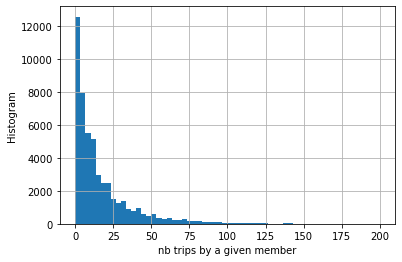

In [30]:
fig, ax = plt.subplots(1, 1)
ax.hist(member_ids, bins=60, range=(0, 200))
ax.set_xlabel("nb trips by a given member")
ax.set_ylabel("Histogram")
ax.grid(True)

## Each member ID has a certain number of PNRs
* Plot the histogram of the number of PNRs to get a sense of how often each member id is travelling. 
* Because the member program at Copa only started in 2015, there was a graduate ramp up of members. 
* As a consequence, this histogram might be misleading. Members who travel more might have started earlier in time. It is not clear how to create a plot that is more meaningful. 

In [31]:
member_ids_pnr = df1.groupby(["MEMBER_ID", "PNR"]).size()

## Some members have multiple entries with the same PNR. 
-  should not happen

In [32]:
member_ids_pnr.max()

5

In [33]:
df1.columns

Index(['MEMBER_ID', 'PNR', 'BOOKING_DATE', 'FLIGHT_DATE', 'TICKET_SALES_DATE',
       'REVENUE_AMOUNT', 'AWARD_MILES', 'FLOWN_CLASS', 'AMOUNT_OF_BAGS',
       'TRUE_OD', 'HOLDING_OD', 'SEGMENT_OD', 'SEGMENT_ORIGIN_REGION',
       'SEGMENT_DESTINATION_REGION', 'SEGMENT_ORIGIN_COUNTRY',
       'SEGMENT_DESTINATION_COUNTRY', 'TICKET_NUMBER',
       'OPERATING_FLIGHT_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'TRUE_DESTINATION_COUNTRY', 'ADDR_COUNTRY', 'OPERATING_COMPANY',
       'ISSUING_COMPANY', 'PARTY_SZ'],
      dtype='object')

## Collect all records where a member has multiple identical PNRs. Analyze. 

In [34]:
df1['multi_pnr'] = df1.groupby(['MEMBER_ID', 'PNR'])['REVENUE_AMOUNT'].transform('size') # BIG ERROR

In [35]:
display(cols_pnr, df1.columns, df[cols_pnr].head())

['PNR',
 'FLIGHT_DATE',
 'OPERATING_FLIGHT_NUMBER',
 'SEGMENT_OD',
 'TRUE_OD',
 'TICKET_NUMBER']

Index(['MEMBER_ID', 'PNR', 'BOOKING_DATE', 'FLIGHT_DATE', 'TICKET_SALES_DATE',
       'REVENUE_AMOUNT', 'AWARD_MILES', 'FLOWN_CLASS', 'AMOUNT_OF_BAGS',
       'TRUE_OD', 'HOLDING_OD', 'SEGMENT_OD', 'SEGMENT_ORIGIN_REGION',
       'SEGMENT_DESTINATION_REGION', 'SEGMENT_ORIGIN_COUNTRY',
       'SEGMENT_DESTINATION_COUNTRY', 'TICKET_NUMBER',
       'OPERATING_FLIGHT_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'TRUE_DESTINATION_COUNTRY', 'ADDR_COUNTRY', 'OPERATING_COMPANY',
       'ISSUING_COMPANY', 'PARTY_SZ', 'multi_pnr'],
      dtype='object')

,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER
0,DSBV1K,1547856000,441,PTY-MIA,PTY-MIA,2.302170e+12
1,DZK5QL,1558483200,142,PTY-SJU,PTY-SJU,2.302172e+12
2,DSCD3O,1562457600,CM0725,PTY-GRU,SJO-GRU,2.305068e+12
3,DZJXX0,1513036800,CM0163,MGA-SJO,MGA-SJO,2.305959e+12
4,E0TNQT,1576022400,CM0710,MGA-PTY,MGA-PTY,2.302173e+12


In [36]:
cols_pnr

['PNR',
 'FLIGHT_DATE',
 'OPERATING_FLIGHT_NUMBER',
 'SEGMENT_OD',
 'TRUE_OD',
 'TICKET_NUMBER']

# Why do some ticket numbers appear multiple times? (max = 3)

In [37]:
df1g = df1.groupby('TICKET_NUMBER').size().max()
df1g

3

In [38]:
df1['ticket_number_dup'] = df1.groupby('TICKET_NUMBER')['PNR'].transform("size")

In [39]:
records_ticket_number_dups = df1[df1['ticket_number_dup'] > 1]
#records_ticket_number_dups[cols_pnr]
records_ticket_number_dups.sort_values('PNR')[cols_pnr + ['MEMBER_ID']].head(50)


,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER,MEMBER_ID
580529,6v2ydm,1493337600,0568,PTY-PUJ,PTY-PUJ,2.302167e+12,234291225
580788,A01TSR,1518307200,CM0456,PTY-LAS,PTY-LAS,2.302169e+12,231438552
580787,A01TSR,1518307200,0456,PTY-LAS,PTY-LAS,2.302169e+12,231438552
581358,A05TMS,1484956800,CM0627,PTY-BOG,PTY-BOG,2.302167e+12,230016056
581359,A05TMS,1491523200,CM0159,PTY-UIO,PTY-UIO,2.302167e+12,230016056
581227,A0A3MY,1558828800,CM0496,PTY-GUA,PTY-GUA,2.302171e+12,230486445
581226,A0A3MY,1558224000,CM0870,PTY-SAL,PTY-SAL,2.302171e+12,230486445
580823,A0CNBN,1514246400,CM0164,SJO-MGA,PTY-MGA,2.302169e+12,231257473
580822,A0CNBN,1513641600,CM0194,PTY-MEX,PTY-MEX,2.302169e+12,231257473
581021,A0E3BZ,1561161600,CM0334,PTY-MIA,PTY-MIA,2.302172e+12,230055794


In [40]:
u.keep_only(records_ticket_number_dups, 'PNR', 'A0KJQR')[cols_pnr + ['MEMBER_ID', 'BOOKING_DATE']]

,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER,MEMBER_ID,BOOKING_DATE
579664,A0KJQR,1575331200,CM0682,PTY-SAL,PTY-SAL,2.302173e+12,230903483,1573689600
579665,A0KJQR,1576022400,CM0144,PTY-SJO,PTY-SJO,2.302173e+12,230903483,1573689600


## Same ticket number for a given itinerary. But can one have the same ticket for two different flights, on different days? 

In [41]:
df1.shape

(865446, 26)

In [42]:
df.columns

Index(['MEMBER_ID', 'PNR', 'BOOKING_DATE', 'FLIGHT_DATE', 'TICKET_SALES_DATE',
       'REVENUE_AMOUNT', 'AWARD_MILES', 'FLOWN_CLASS', 'AMOUNT_OF_BAGS',
       'TRUE_OD', 'HOLDING_OD', 'SEGMENT_OD', 'SEGMENT_ORIGIN_REGION',
       'SEGMENT_DESTINATION_REGION', 'SEGMENT_ORIGIN_COUNTRY',
       'SEGMENT_DESTINATION_COUNTRY', 'TICKET_NUMBER',
       'OPERATING_FLIGHT_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'TRUE_DESTINATION_COUNTRY', 'ADDR_COUNTRY', 'OPERATING_COMPANY',
       'ISSUING_COMPANY', 'PARTY_SZ'],
      dtype='object')

In [43]:
# flight starts and ends in Panama (the country)
df[df["PNR"] == "AOD22V"][cols_pnr + ["ADDR_COUNTRY"]].sort_values(
    ["TRUE_OD", "TICKET_NUMBER"]
)

,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER,ADDR_COUNTRY


In [44]:
# Should not happen. The same flight. Single PNR, several ticket numbers the same.
# These must have been candcelations and rebookings?
df_pnr = df[df["PNR"] == "BYQNXF"][cols_pnr + ["ADDR_COUNTRY"]].sort_values(
    ["TRUE_OD", "TICKET_NUMBER"]
)
df_pnr

,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER,ADDR_COUNTRY
663886,BYQNXF,1496620800,0498,PTY-MSY,PTY-MSY,2.302168e+12,Panama
663887,BYQNXF,1496620800,CM0498,PTY-MSY,PTY-MSY,2.302168e+12,Panama


In [45]:
# Should not happen. The same flight. Single PNR, several ticket numbers the same.
# These must have been candcelations and rebookings?
df_pnr = df1[df1["PNR"] == "BYQNXF"][cols_pnr + ["ADDR_COUNTRY", "MEMBER_ID"]].sort_values(
    ["TRUE_OD", "TICKET_NUMBER"]
)
df_pnr

,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER,ADDR_COUNTRY,MEMBER_ID
663886,BYQNXF,1496620800,0498,PTY-MSY,PTY-MSY,2.302168e+12,Panama,230038213
663887,BYQNXF,1496620800,CM0498,PTY-MSY,PTY-MSY,2.302168e+12,Panama,230038213


In [46]:
# TODO: Remove all rows where a (FLIGHT_NUMBER, TICKET_NUMBER) has duplicates. (keep only one row)

In [47]:
# The next two records are identical.
# QUESTION: Are they identical in the original Data Frame?

In [48]:
df.loc[788084]

MEMBER_ID                               246615204
PNR                                        BAY3GX
BOOKING_DATE                           1544745600
FLIGHT_DATE                            1545004800
TICKET_SALES_DATE                      1544745600
REVENUE_AMOUNT                                210
AWARD_MILES                                   916
FLOWN_CLASS                                     S
AMOUNT_OF_BAGS                                  0
TRUE_OD                                   SDQ-PTY
HOLDING_OD                                SDQ-PTY
SEGMENT_OD                                SDQ-PTY
SEGMENT_ORIGIN_REGION                         CAR
SEGMENT_DESTINATION_REGION                    HUB
SEGMENT_ORIGIN_COUNTRY         DOMINICAN REPUBLIC
SEGMENT_DESTINATION_COUNTRY                PANAMA
TICKET_NUMBER                     2307230150159.0
OPERATING_FLIGHT_NUMBER                    CM0557
TRUE_ORIGIN_COUNTRY            DOMINICAN REPUBLIC
TRUE_DESTINATION_COUNTRY                   PANAMA


In [49]:
df.loc[788085]

MEMBER_ID                            230036157
PNR                                     BAY2UB
BOOKING_DATE                       -2208988800
FLIGHT_DATE                         1451606400
TICKET_SALES_DATE                   1447977600
REVENUE_AMOUNT                             459
AWARD_MILES                               5266
FLOWN_CLASS                                  K
AMOUNT_OF_BAGS                               2
TRUE_OD                                GYE-LAX
HOLDING_OD                             GYE-LAX
SEGMENT_OD                             PTY-LAX
SEGMENT_ORIGIN_REGION                      HUB
SEGMENT_DESTINATION_REGION             WESTNAM
SEGMENT_ORIGIN_COUNTRY                  PANAMA
SEGMENT_DESTINATION_COUNTRY      UNITED STATES
TICKET_NUMBER                  2302164647664.0
OPERATING_FLIGHT_NUMBER                 CM0472
TRUE_ORIGIN_COUNTRY                    ECUADOR
TRUE_DESTINATION_COUNTRY         UNITED STATES
ADDR_COUNTRY                           Ecuador
OPERATING_COM

# Why read the "MEMBERS_ACTIVITY_FILE"
Perform some kind of check.

In [50]:
if False:
    df00 = u.read_activity_file()
    df00_pnr = df00[df00["PNR"] == "BYQNXF"]
    df00_pnr[cols_pnr + ["MEMBER_ID"]]

In [51]:
df_pnr

,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER,ADDR_COUNTRY,MEMBER_ID
663886,BYQNXF,1496620800,0498,PTY-MSY,PTY-MSY,2.302168e+12,Panama,230038213
663887,BYQNXF,1496620800,CM0498,PTY-MSY,PTY-MSY,2.302168e+12,Panama,230038213


In [52]:
df_pnr[cols_pnr + ["MEMBER_ID"]]  # MEMBER_ID not in list

,PNR,FLIGHT_DATE,OPERATING_FLIGHT_NUMBER,SEGMENT_OD,TRUE_OD,TICKET_NUMBER,MEMBER_ID
663886,BYQNXF,1496620800,0498,PTY-MSY,PTY-MSY,2.302168e+12,230038213
663887,BYQNXF,1496620800,CM0498,PTY-MSY,PTY-MSY,2.302168e+12,230038213


In [53]:
df_pnr.columns

Index(['PNR', 'FLIGHT_DATE', 'OPERATING_FLIGHT_NUMBER', 'SEGMENT_OD',
       'TRUE_OD', 'TICKET_NUMBER', 'ADDR_COUNTRY', 'MEMBER_ID'],
      dtype='object')

---
## Let us construct a list of members and ODs and flight dates


In [54]:
df1.columns

Index(['MEMBER_ID', 'PNR', 'BOOKING_DATE', 'FLIGHT_DATE', 'TICKET_SALES_DATE',
       'REVENUE_AMOUNT', 'AWARD_MILES', 'FLOWN_CLASS', 'AMOUNT_OF_BAGS',
       'TRUE_OD', 'HOLDING_OD', 'SEGMENT_OD', 'SEGMENT_ORIGIN_REGION',
       'SEGMENT_DESTINATION_REGION', 'SEGMENT_ORIGIN_COUNTRY',
       'SEGMENT_DESTINATION_COUNTRY', 'TICKET_NUMBER',
       'OPERATING_FLIGHT_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'TRUE_DESTINATION_COUNTRY', 'ADDR_COUNTRY', 'OPERATING_COMPANY',
       'ISSUING_COMPANY', 'PARTY_SZ', 'multi_pnr', 'ticket_number_dup'],
      dtype='object')

# Output data after reduction of extraneous records

In [55]:
df11 = df1.copy()

In [56]:
df11['D'] = df1.loc[:, 'TRUE_OD'].str[4:]

In [57]:
# Starting point for attribute calculation
df11.to_csv("activity_reduced_before_attributes.csv", index=0)
df11.shape

(865446, 27)

In [58]:
df1 = df11.copy()

# Create month and day of week columns for Booking date and flight date
Column names: book_mo, book_dofwk, flight_mo, flight_daywk

In [59]:
import date_library as dlib 
dfx = df.iloc[0:10000]
dfxx = dfx['FLIGHT_DATE'].apply(dlib.timestampToDateTimePTY).apply(lambda x: x[0])
#dlib.timestampToDateTimePTY(dfx['FLIGHT_DATE'].iloc[0])
dfxx.max()

'2022-02-14'

In [60]:
pd.to_datetime(df['BOOKING_DATE'])

0        1970-01-01 00:00:01.529366400
1        1970-01-01 00:00:01.557878400
2        1970-01-01 00:00:01.560729600
3        1970-01-01 00:00:01.511740800
4        1970-01-01 00:00:01.575244800
                      ...             
865441   1970-01-01 00:00:01.463529600
865442   1970-01-01 00:00:01.531094400
865443   1970-01-01 00:00:01.522972800
865444   1970-01-01 00:00:01.624924800
865445   1970-01-01 00:00:01.483574400
Name: BOOKING_DATE, Length: 865446, dtype: datetime64[ns]

In [61]:
%%time
df1 = df.copy()
df1.columns

CPU times: user 37.6 ms, sys: 32.4 ms, total: 70 ms
Wall time: 69.2 ms


Index(['MEMBER_ID', 'PNR', 'BOOKING_DATE', 'FLIGHT_DATE', 'TICKET_SALES_DATE',
       'REVENUE_AMOUNT', 'AWARD_MILES', 'FLOWN_CLASS', 'AMOUNT_OF_BAGS',
       'TRUE_OD', 'HOLDING_OD', 'SEGMENT_OD', 'SEGMENT_ORIGIN_REGION',
       'SEGMENT_DESTINATION_REGION', 'SEGMENT_ORIGIN_COUNTRY',
       'SEGMENT_DESTINATION_COUNTRY', 'TICKET_NUMBER',
       'OPERATING_FLIGHT_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'TRUE_DESTINATION_COUNTRY', 'ADDR_COUNTRY', 'OPERATING_COMPANY',
       'ISSUING_COMPANY', 'PARTY_SZ'],
      dtype='object')

In [62]:
%%time 
df1 = df.copy()
df1 = u.get_dayofweek_month(df1, df_date_col='FLIGHT_DATE', labels=('FLIGHT_date', 'FLIGHT_mo', 'FLIGHT_daywk'))
# df1.columns
df2 = u.get_dayofweek_month(df1, df_date_col='BOOKING_DATE', labels=('BOOKING_date', 'BOOKING_mo', 'BOOKING_daywk'))

CPU times: user 4.4 s, sys: 448 ms, total: 4.85 s
Wall time: 4.86 s


In [63]:
df3 = df2.copy()

In [64]:
# nb weeks between booking and flight
df2['wks_from_booking_to_flight'] = (df2['FLIGHT_DATE'] - df2['BOOKING_DATE']) / (7 * 24 * 3600)

In [65]:
wks_bookings_to_flight = df2[df2['wks_from_booking_to_flight'] > 0]['wks_from_booking_to_flight'].sort_values().value_counts().head(50)

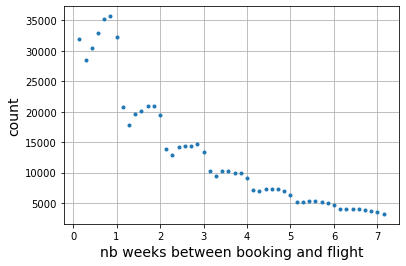

In [66]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(wks_bookings_to_flight.index, wks_bookings_to_flight, ".")
ax.set_xlabel("nb weeks between booking and flight", fontsize=14)
ax.set_ylabel("count", fontsize=14)
plt.grid(True)

In [67]:
df2.columns

Index(['MEMBER_ID', 'PNR', 'BOOKING_DATE', 'FLIGHT_DATE', 'TICKET_SALES_DATE',
       'REVENUE_AMOUNT', 'AWARD_MILES', 'FLOWN_CLASS', 'AMOUNT_OF_BAGS',
       'TRUE_OD', 'HOLDING_OD', 'SEGMENT_OD', 'SEGMENT_ORIGIN_REGION',
       'SEGMENT_DESTINATION_REGION', 'SEGMENT_ORIGIN_COUNTRY',
       'SEGMENT_DESTINATION_COUNTRY', 'TICKET_NUMBER',
       'OPERATING_FLIGHT_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'TRUE_DESTINATION_COUNTRY', 'ADDR_COUNTRY', 'OPERATING_COMPANY',
       'ISSUING_COMPANY', 'PARTY_SZ', 'FLIGHT_date', 'FLIGHT_daywk',
       'FLIGHT_mo', 'BOOKING_date', 'BOOKING_daywk', 'BOOKING_mo',
       'wks_from_booking_to_flight'],
      dtype='object')

In [68]:
def get_dates(ix):
    flight = df['FLIGHT_DATE'].iloc[ix]
    booking = df['BOOKING_DATE'].iloc[ix]
    flight_date = datelib.timestampToDateTimePTY(flight)
    booking_date = datelib.timestampToDateTimePTY(booking)
    return flight_date, booking_date

In [69]:
for ix in range(20):
    print(get_dates(ix))

(('2019-01-19', '05:00'), ('2018-06-19', '05:00'))
(('2019-05-22', '05:00'), ('2019-05-15', '05:00'))
(('2019-07-07', '05:00'), ('2019-06-17', '05:00'))
(('2017-12-12', '05:00'), ('2017-11-27', '05:00'))
(('2019-12-11', '05:00'), ('2019-12-02', '05:00'))
(('2019-10-15', '05:00'), ('2019-07-25', '05:00'))
(('2017-10-25', '05:00'), ('2017-10-18', '05:00'))
(('2018-03-22', '05:00'), ('2017-11-26', '05:00'))
(('2018-02-06', '05:00'), ('2017-11-27', '05:00'))
(('2016-01-18', '05:00'), ('2016-01-18', '05:00'))
(('2018-09-26', '05:00'), ('2018-09-14', '05:00'))
(('2017-04-27', '05:00'), ('2017-04-12', '05:00'))
(('2018-06-20', '05:00'), ('2018-01-12', '05:00'))
(('2015-09-14', '05:00'), ('1900-01-01', '05:00'))
(('2019-10-12', '05:00'), ('2019-09-24', '05:00'))
(('2017-10-26', '05:00'), ('2017-10-18', '05:00'))
(('2019-07-02', '05:00'), ('2019-06-17', '05:00'))
(('2019-11-13', '05:00'), ('2019-11-02', '05:00'))
(('2016-02-29', '05:00'), ('2016-01-18', '05:00'))
(('2018-05-24', '05:00'), ('201

In [70]:
df2[['wks_from_booking_to_flight','BOOKING_mo', 'FLIGHT_mo']]
# df2['FLIGHT_DATE']

,wks_from_booking_to_flight,BOOKING_mo,FLIGHT_mo
0,30.571429,6,1
1,14.142857,6,9
2,0.142857,6,6
3,0.142857,6,6
4,0.142857,6,6
...,...,...,...
865441,14.428571,3,6
865442,8.571429,3,5
865443,14.571429,3,6
865444,19.571429,3,7


In [71]:
df2[['BOOKING_mo','FLIGHT_mo','BOOKING_daywk','FLIGHT_daywk']].head(50)


,BOOKING_mo,FLIGHT_mo,BOOKING_daywk,FLIGHT_daywk
0,6,1,1,5
1,6,9,1,2
2,6,6,1,2
3,6,6,1,2
4,6,6,1,2
5,6,6,1,2
6,6,6,1,2
7,6,6,1,2
8,6,6,1,2
9,6,6,1,2


# Work with member_od

## A triplet (MEMBER_ID, Destination, FLIGHT_DATE) is a unique itinerary for our recommender
This will decrease the number of rows slightly.

In [80]:
df1["D"] = df1["TRUE_OD"].str[4:7]

In [81]:
member_od = df1[['MEMBER_ID','TRUE_OD','D', 'FLIGHT_DATE','BOOKING_DATE','TICKET_SALES_DATE',
                 'TICKET_NUMBER','TRUE_ORIGIN_COUNTRY','ADDR_COUNTRY','PNR', 'PARTY_SZ']].sort_values('MEMBER_ID')

group_cols = ['MEMBER_ID', 'D', 'FLIGHT_DATE']
member_od_g = member_od.groupby(group_cols).size().to_frame('size').reset_index().sort_values('size', ascending=False)
member_od['size'] = member_od.groupby(group_cols)['BOOKING_DATE'].transform('size')

member_od_g.shape, member_od_g.columns, member_od_g.groupby('size').count()

((849491, 4),
 Index(['MEMBER_ID', 'D', 'FLIGHT_DATE', 'size'], dtype='object'),
       MEMBER_ID       D  FLIGHT_DATE
 size                                
 1        835129  835129       835129
 2         13166   13166        13166
 3           958     958          958
 4           166     166          166
 5            36      36           36
 6            20      20           20
 7             4       4            4
 8             8       8            8
 10            2       2            2
 12            1       1            1
 23            1       1            1)

In [82]:
member_od.columns

Index(['MEMBER_ID', 'TRUE_OD', 'D', 'FLIGHT_DATE', 'BOOKING_DATE',
       'TICKET_SALES_DATE', 'TICKET_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'ADDR_COUNTRY', 'PNR', 'PARTY_SZ', 'size'],
      dtype='object')

In [83]:
df1.columns

Index(['MEMBER_ID', 'PNR', 'BOOKING_DATE', 'FLIGHT_DATE', 'TICKET_SALES_DATE',
       'REVENUE_AMOUNT', 'AWARD_MILES', 'FLOWN_CLASS', 'AMOUNT_OF_BAGS',
       'TRUE_OD', 'HOLDING_OD', 'SEGMENT_OD', 'SEGMENT_ORIGIN_REGION',
       'SEGMENT_DESTINATION_REGION', 'SEGMENT_ORIGIN_COUNTRY',
       'SEGMENT_DESTINATION_COUNTRY', 'TICKET_NUMBER',
       'OPERATING_FLIGHT_NUMBER', 'TRUE_ORIGIN_COUNTRY',
       'TRUE_DESTINATION_COUNTRY', 'ADDR_COUNTRY', 'OPERATING_COMPANY',
       'ISSUING_COMPANY', 'PARTY_SZ', 'FLIGHT_date', 'FLIGHT_daywk',
       'FLIGHT_mo', 'D'],
      dtype='object')

In [84]:
member_od[(member_od['TICKET_SALES_DATE'] != member_od['BOOKING_DATE'])].head()

,MEMBER_ID,TRUE_OD,D,FLIGHT_DATE,BOOKING_DATE,TICKET_SALES_DATE,TICKET_NUMBER,TRUE_ORIGIN_COUNTRY,ADDR_COUNTRY,PNR,PARTY_SZ,size
563844,100031203,PTY-SJO,SJO,1531785600,1531180800,1531267200,2.302699e+12,PANAMA,Panama,BUBD1Q,1,1
435221,100031203,PTY-LIR,LIR,1484438400,1484006400,1484092800,2.301157e+12,PANAMA,Panama,GJQG0D,1,1
613987,100031203,PTY-LIR,LIR,1480809600,1480550400,1480636800,2.301157e+12,PANAMA,Panama,BT35GI,1,1
501342,100031203,PTY-LIR,LIR,1508025600,1506902400,1506988800,2.305734e+12,PANAMA,Panama,A4WCA2,1,1
40276,100031203,PTY-SJO,SJO,1538092800,1536192000,1536278400,2.302747e+12,PANAMA,Panama,BHN2BL,1,1


In [85]:
member_od[member_od['size'] == 2].head()

,MEMBER_ID,TRUE_OD,D,FLIGHT_DATE,BOOKING_DATE,TICKET_SALES_DATE,TICKET_NUMBER,TRUE_ORIGIN_COUNTRY,ADDR_COUNTRY,PNR,PARTY_SZ,size
831801,100041364,PTY-UIO,UIO,1640044800,1629676800,1629590400,2.302176e+12,PANAMA,Panama,AVK2DJ,1,2
831802,100041364,PTY-UIO,UIO,1640044800,1629676800,1629590400,2.302176e+12,PANAMA,Panama,AVJP0Y,1,2
775346,100052785,PTY-ORD,ORD,1629158400,1627344000,1627344000,2.302176e+12,PANAMA,Panama,BLR25C,1,2
775349,100052785,PTY-ORD,ORD,1629158400,1627344000,1627344000,2.302176e+12,PANAMA,Panama,BLMNBA,1,2
97677,100054148,SDQ-PEI,PEI,1536710400,1536624000,1536624000,2.302170e+12,DOMINICAN REPUBLIC,Dominican Republic,CGNZGE,1,2


In [86]:
# Adding all the values returns member_od.shape[0]
member_od['size'].value_counts(), member_od.shape[0]

(1     835129
 2      26332
 3       2874
 4        664
 5        180
 6        120
 8         64
 7         28
 23        23
 10        20
 12        12
 Name: size, dtype: int64,
 865446)

In [87]:
member_od.shape, member_od.columns

((865446, 12),
 Index(['MEMBER_ID', 'TRUE_OD', 'D', 'FLIGHT_DATE', 'BOOKING_DATE',
        'TICKET_SALES_DATE', 'TICKET_NUMBER', 'TRUE_ORIGIN_COUNTRY',
        'ADDR_COUNTRY', 'PNR', 'PARTY_SZ', 'size'],
       dtype='object'))

In [88]:
member_od = member_od[member_od['size'] == 1]
member_od.shape, member_od_g.shape, member_od.columns

((835129, 12),
 (849491, 4),
 Index(['MEMBER_ID', 'TRUE_OD', 'D', 'FLIGHT_DATE', 'BOOKING_DATE',
        'TICKET_SALES_DATE', 'TICKET_NUMBER', 'TRUE_ORIGIN_COUNTRY',
        'ADDR_COUNTRY', 'PNR', 'PARTY_SZ', 'size'],
       dtype='object'))

In [89]:
member_od.to_csv("member_d.csv", index=0)
member_od_g.shape

(849491, 4)

In [90]:
!pwd

/home/erlebach/src/2022/copa_recommenders


In [91]:
member_od_g

,MEMBER_ID,D,FLIGHT_DATE,size
604495,234605013,CUN,1613174400,23
325503,231216383,PTY,1576022400,12
474812,232345398,PTY,1552348800,10
665291,236444215,PTY,1578268800,10
333323,231250764,PTY,1510617600,8
...,...,...,...,...
286052,230918334,PTY,1575504000,1
286053,230918334,SDQ,1454544000,1
286054,230918592,HAV,1583539200,1
286055,230918592,MIA,1539648000,1


In [92]:
member_od_g.shape, member_od.shape

((849491, 4), (835129, 12))